# Comparing estimators for π₀

## Setting the scene

In [1]:
using MultipleTesting

In [2]:
using Distributions
using DataFrames
using Gadfly

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/julian/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


In [3]:
import Random
Random.seed!(42);

## Simulating p-value distributions

We simulate p-values under the null and alternative hypothesis by drawing from random variable distributions. For the null hypothesis, p-values are uniformly distributed in the interval [0,1]; p-values under the alternative hypothesis are modelled by a Beta distribution with a momotonically decreasing density.

In [4]:
π₀ = 0.7
bum = BetaUniformMixtureModel(π₀, 0.5, 3.0)

MixtureModel{Distribution{Univariate,Continuous}}(K = 2)
components[1] (prior = 0.3000): Beta{Float64}(α=0.5, β=3.0)
components[2] (prior = 0.7000): Uniform{Float64}(a=0.0, b=1.0)


In [5]:
h₁, h₀ = components(bum);

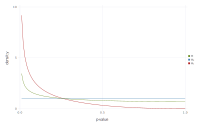

In [6]:
x = range(0.01, stop = 1.0, step = 0.01);
colors = ["olive drab", "steel blue", "firebrick"]
p = plot(
         layer(x = x, y = pdf.(bum, x), Geom.line, Theme(default_color = colors[1])),
         layer(x = x, y = pdf.(h₀, x), Geom.line, Theme(default_color = colors[2])),
         layer(x = x, y = pdf.(h₁, x), Geom.line, Theme(default_color = colors[3])),
         Guide.xlabel("p-value"), Guide.ylabel("density"),
         Guide.manual_color_key("", ["H", "H₀", "H₁"], colors)
)
draw(SVG(20cm, 13cm), p)

## Assessing π₀ estimators

We assess the performance of three estimators for π₀, the fraction of tests under the null hypothesis. Here, we compare different estimators in the package (skipping the Oracle one though, for obvious reasons). Using the mixture model from above, we simulate p-values with a true π₀ of 0.7, i.e. 30% of the p-values come from the alternative model.

In [7]:
estimators = filter(x -> x.name.name != :Oracle, subtypes(Pi0Estimator))

9-element Array{Any,1}:
 BUM             
 CensoredBUM     
 ConvexDecreasing
 FlatGrenander   
 LeastSlope      
 RightBoundary   
 Storey          
 StoreyBootstrap 
 TwoStep         

In [8]:
m = 200;

In [9]:
pi0hat = zeros(m, length(estimators))
for i in 1:m
    pvals = PValues(rand(bum, m))
    for (j, e) in enumerate(estimators)
        pi0hat[i,j] = estimate_pi0(pvals, e())
    end
end

In [10]:
df = convert(DataFrame, pi0hat)
names!(df, [e.name.name for e in estimators])
df = stack(df, collect(1:length(estimators)))
names!(df, [:estimator, :π̂₀]);

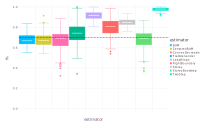

In [11]:
p = plot(
         layer(yintercept = [π₀], Geom.hline(style = :dot, color = "black")),
         layer(df, x = :estimator, y = :π̂₀, color = :estimator, Geom.boxplot),
         Scale.x_discrete(labels = x -> ""),
         Guide.yticks(ticks = collect(0:0.2:1))
)
f = draw(SVG(20cm, 13cm), p)

Visualizing the estimated π₀ for the estimators shows us a typical bias-variance tradeoff: For example, Storey's bootstrap has a small bias with regard to the true value (black horizontal line), but exhibits a large degree of variablity. In contrast, the Two Step and the Least Slope estimators have lower variability, while clearly overestimating π₀.